[**Link here**](https://www.kaggle.com/datasets/forderation/breakhis-400x)

 **Download the dataset from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "shenhav026" # username from the json file
os.environ['KAGGLE_KEY'] = "fecdd1158d18301e53d18c19ed884477" # key from the json file

In [ ]:
! kaggle datasets download -d forderation/breakhis-400x

100% 801M/803M [00:07<00:00, 123MB/s]
100% 803M/803M [00:07<00:00, 107MB/s]


In [ ]:
! mkdir dataset
! unzip breakhis-400x.zip -d dataset

Archive:  breakhis-400x.zip
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-001.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-005.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-007.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-011.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-015.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-019.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-027.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-028.png  
  inflating: dataset/BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png  
  inflating:

In [ ]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201,DenseNet121 , InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter

%matplotlib inline
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 16

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/dataset/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:04<00:00, 79.88it/s]


In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
label =  {0:"benign",1:"malignant"}

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

**DenseNet-121 model**

In [ ]:
def create_densenet121():
    base_model = DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3))
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))

    for layer in base_model.layers:
     layer.trainable = False
    #early stop  to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

    device_name = tf.test.gpu_device_name()
    if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
    else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

    with tf.device(device_name):
       opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
       model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
       #history = model.fit(train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),steps_per_epoch=x_train.shape[0] / BATCH_SIZE,epochs=5,validation_data=(x_val, y_val),callbacks=[es])
       #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=5, batch_size=16,callbacks=[es])
       history1 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)
       loss_value_test , accuracy_test = model.evaluate(X_test, Y_test)
       loss_value_train , accuracy_train = model.evaluate(x_train, y_train)


    Acc_Epochs_Plot(history1)
    print('Test_loss_train_value = ' +str(loss_value_train))
    print('test_accuracy_train = ' + str(accuracy_train))

    print('Test_loss_value = ' +str(loss_value_test))
    print('test_accuracy = ' + str(accuracy_test))
    return model


Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 11s 229ms/step - loss: 0.6956 - accuracy: 0.6281 - val_loss: 0.9706 - val_accuracy: 0.7826
Epoch 2/50
12/12 [==============================] - 1s 49ms/step - loss: 0.5667 - accuracy: 0.7384 - val_loss: 0.6543 - val_accuracy: 0.8315
Epoch 3/50
12/12 [==============================] - 1s 49ms/step - loss: 0.5568 - accuracy: 0.7302 - val_loss: 0.5167 - val_accuracy: 0.8098
Epoch 4/50
12/12 [==============================] - 1s 48ms/step - loss: 0.5201 - accuracy: 0.7561 - val_loss: 0.3594 - val_accuracy: 0.8859
Epoch 5/50
12/12 [==============================] - 1s 50ms/step - loss: 0.4751 - accuracy: 0.7956 - val_loss: 0.3323 - val_accuracy: 0.8750
Epoch 6/50
12/12 [==============================] - 1s 49ms/step - loss: 0.4903 - accuracy: 0.8011 - val_loss: 0.3366 - val_accuracy: 0.8804
Epoch 7/50
12/12 [==============================] - 1s 52ms/step - loss: 0.4342 - accuracy: 0.8188 - val_loss: 0.3279 - val_

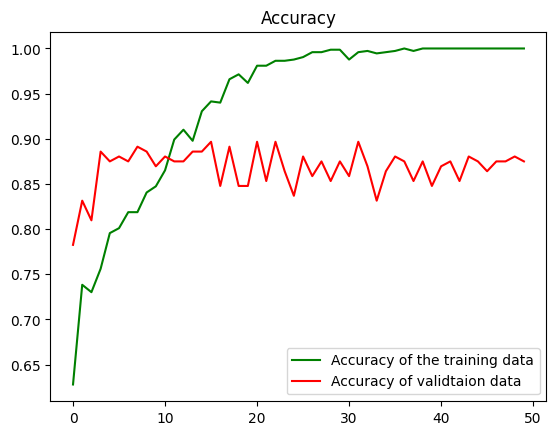

<Figure size 640x480 with 0 Axes>

Test_loss_train_value = 0.07772151380777359
test_accuracy_train = 0.9749455451965332
Test_loss_value = 0.49163639545440674
test_accuracy = 0.8660550713539124


In [ ]:
densenet_121 = create_densenet121()

In [ ]:
densenet_121.save_weights(filepath="/content/drive/MyDrive/Models/densenet121_hist/", overwrite=True, save_format=None, options=None)

**Inception V3 Model**

In [ ]:
def create_inceptionV3():
    base_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))

    for layer in base_model.layers:
     layer.trainable = False
    #early stop  to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

    device_name = tf.test.gpu_device_name()
    if len(device_name) > 0:
      print("Found GPU at: {}".format(device_name))
    else:
      device_name = "/device:CPU:0"
      print("No GPU, using {}.".format(device_name))

    with tf.device(device_name):
       #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
       opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
       model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
       #history = model.fit(train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),steps_per_epoch=x_train.shape[0] / BATCH_SIZE,epochs=5,validation_data=(x_val, y_val),callbacks=[es])
       #history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=5, batch_size=16,callbacks=[es])
       history2 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)
       loss_value_test , accuracy_test = model.evaluate(X_test, Y_test)
       loss_value_train , accuracy_train = model.evaluate(x_train, y_train)
    Acc_Epochs_Plot(history2)
    print('Test_loss_train_value = ' +str(loss_value_train))
    print('test_accuracy_train = ' + str(accuracy_train))

    print('Test_loss_value = ' +str(loss_value_test))
    print('test_accuracy = ' + str(accuracy_test))
    return model

Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 7s 159ms/step - loss: 0.7952 - accuracy: 0.5054 - val_loss: 0.8870 - val_accuracy: 0.6957
Epoch 2/50
12/12 [==============================] - 0s 31ms/step - loss: 0.7655 - accuracy: 0.5041 - val_loss: 0.7233 - val_accuracy: 0.6957
Epoch 3/50
12/12 [==============================] - 0s 32ms/step - loss: 0.7586 - accuracy: 0.5191 - val_loss: 0.6821 - val_accuracy: 0.6957
Epoch 4/50
12/12 [==============================] - 0s 32ms/step - loss: 0.7213 - accuracy: 0.5886 - val_loss: 0.6333 - val_accuracy: 0.6957
Epoch 5/50
12/12 [==============================] - 0s 32ms/step - loss: 0.7311 - accuracy: 0.5817 - val_loss: 0.6145 - val_accuracy: 0.6957
Epoch 6/50
12/12 [==============================] - 0s 32ms/step - loss: 0.6933 - accuracy: 0.6185 - val_loss: 0.6054 - val_accuracy: 0.6848
Epoch 7/50
12/12 [==============================] - 0s 32ms/step - loss: 0.6819 - accuracy: 0.6281 - val_loss: 0.6106 - val_a

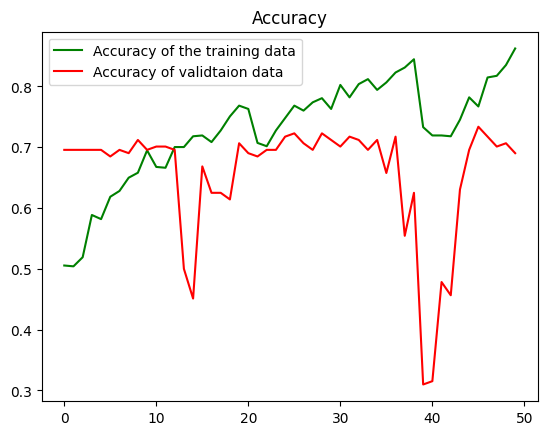

<Figure size 640x480 with 0 Axes>

Test_loss_train_value = 0.5849999189376831
test_accuracy_train = 0.687363862991333
Test_loss_value = 0.709379255771637
test_accuracy = 0.6880733966827393


In [ ]:
inception_v3 = create_inceptionV3()
inception_v3.save_weights(filepath="/content/drive/MyDrive/Models/inception_hist/", overwrite=True, save_format=None, options=None)

#Comparting between the models

Found GPU at: /device:GPU:0
Epoch 1/50
12/12 [==============================] - 11s 242ms/step - loss: 0.6715 - accuracy: 0.6540 - val_loss: 0.8368 - val_accuracy: 0.7717
Epoch 2/50
12/12 [==============================] - 1s 50ms/step - loss: 0.5736 - accuracy: 0.7411 - val_loss: 0.5437 - val_accuracy: 0.8696
Epoch 3/50
12/12 [==============================] - 1s 50ms/step - loss: 0.5418 - accuracy: 0.7589 - val_loss: 0.4083 - val_accuracy: 0.8804
Epoch 4/50
12/12 [==============================] - 1s 49ms/step - loss: 0.5143 - accuracy: 0.7766 - val_loss: 0.3308 - val_accuracy: 0.8750
Epoch 5/50
12/12 [==============================] - 1s 49ms/step - loss: 0.4852 - accuracy: 0.8025 - val_loss: 0.3263 - val_accuracy: 0.8696
Epoch 6/50
12/12 [==============================] - 1s 50ms/step - loss: 0.4680 - accuracy: 0.8161 - val_loss: 0.3262 - val_accuracy: 0.8750
Epoch 7/50
12/12 [==============================] - 1s 49ms/step - loss: 0.4462 - accuracy: 0.8351 - val_loss: 0.3361 - val_

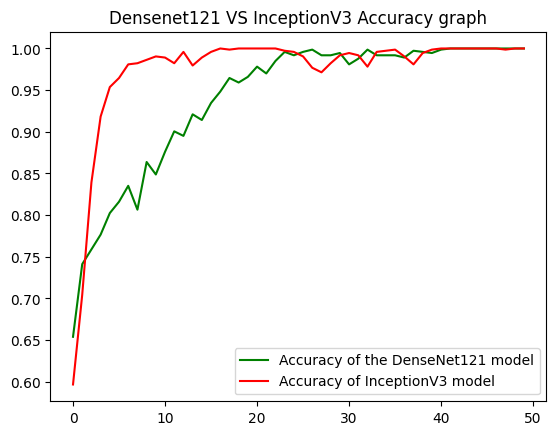

<Figure size 640x480 with 0 Axes>

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3))
model = Sequential()
model.add(base_model)
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False
    #early stop  to avoid overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
   print("Found GPU at: {}".format(device_name))
else:
   device_name = "/device:CPU:0"
   print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
    history1 = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)


base_model2 = InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))
model2 = Sequential()
model2.add(base_model2)
model2.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model2.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model2.add(Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(2, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False
    #early stop  to avoid overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
   print("Found GPU at: {}".format(device_name))
else:
   device_name = "/device:CPU:0"
   print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
   opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
   model2.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
   history2 = model2.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=50, batch_size=64)

Acc_DenseNet121_VS_Inception_Plot(history1,history2)


#Functions

In [ ]:
def Acc_Epochs_Plot(hist):
  get_acc_train = hist.history['accuracy']
  get_acc_val = hist.history['val_accuracy']
  epochs = range(len(get_acc_train))
  plt.plot(epochs, get_acc_train, 'g' , label = 'Accuracy of the training data')
  plt.plot(epochs, get_acc_val, 'r', label = 'Accuracy of validtaion data')
  plt.title('Accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

In [ ]:
def Acc_DenseNet121_VS_Inception_Plot(hist1,hist2):
  get_acc_densnet = hist1.history['accuracy']
  get_acc_inception = hist2.history['accuracy']
  epochs = range(len(get_acc_densnet))
  plt.plot(epochs, get_acc_densnet, 'g' , label = 'Accuracy of the DenseNet121 model')
  plt.plot(epochs, get_acc_inception, 'r', label = 'Accuracy of InceptionV3 model')
  plt.title('Densenet121 VS InceptionV3 Accuracy graph')
  plt.legend(loc=0)
  plt.figure()
  plt.show()